In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/classification

/content/drive/MyDrive/ColabNotebooks/classification


In [3]:
# !unzip -q data.zip

In [4]:
# %pip install wandb
# %pip install torchinfo

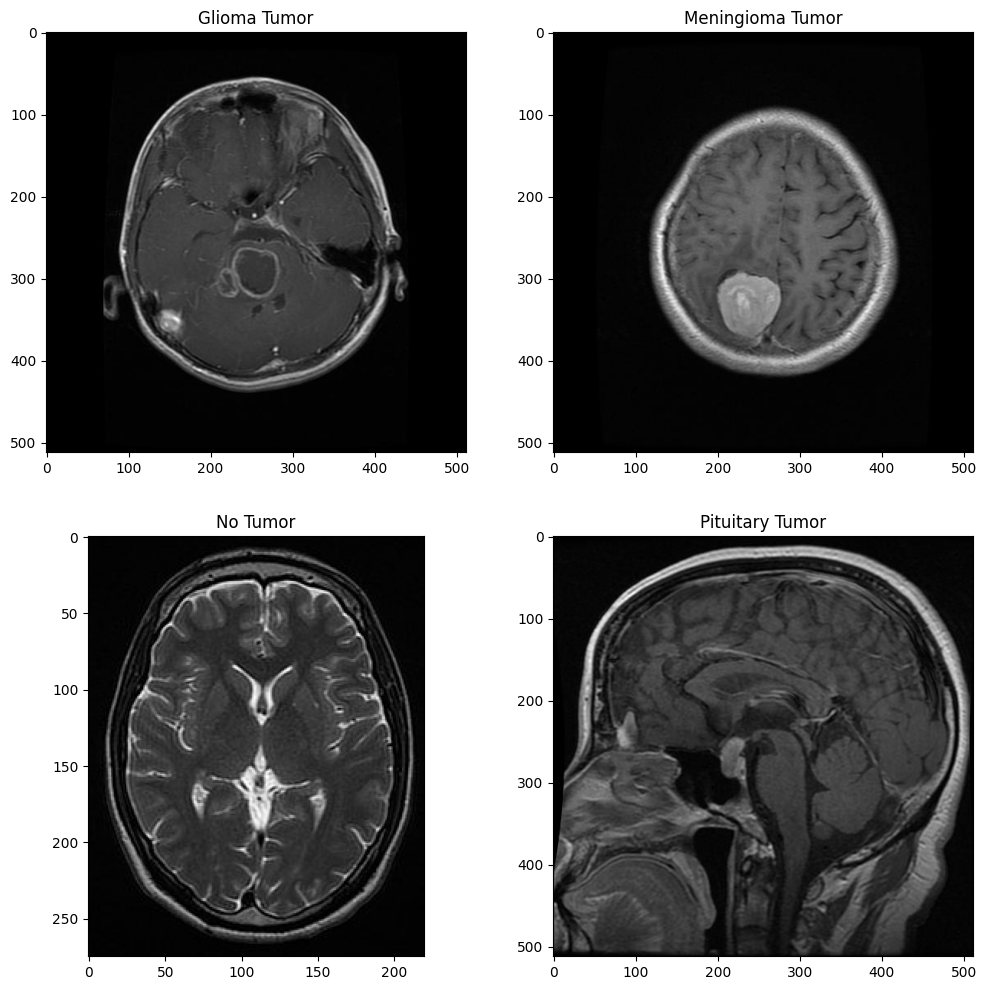

In [5]:
import cv2
import matplotlib.pyplot as plt
import random
import glob

glioma_img = cv2.imread(random.choice(glob.glob("data/Training/glioma_tumor/*.jpg")), cv2.COLOR_BGR2RGB)
meningioma_img = cv2.imread(random.choice(glob.glob("data/Training/meningioma_tumor/*.jpg")), cv2.COLOR_BGR2RGB)
notumor_img = cv2.imread(random.choice(glob.glob("data/Training/no_tumor/*.jpg")), cv2.COLOR_BGR2RGB)
pituitary_img = cv2.imread(random.choice(glob.glob("data/Training/pituitary_tumor/*.jpg")), cv2.COLOR_BGR2RGB)

fix, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].set_title("Glioma Tumor")
axes[0, 0].imshow(glioma_img)

axes[0, 1].set_title("Meningioma Tumor")
axes[0, 1].imshow(meningioma_img)

axes[1, 0].set_title("No Tumor")
axes[1, 0].imshow(notumor_img)

axes[1, 1].set_title("Pituitary Tumor")
axes[1, 1].imshow(pituitary_img)



In [6]:

print("number of glioma tumor", len(glob.glob("data/Training/glioma_tumor/*.jpg")))
print("number of meningioma tumor", len(glob.glob("data/Training/meningioma_tumor/*.jpg")))
print("number of no tumor", len(glob.glob("data/Training/no_tumor/*.jpg")))
print("number of pituitary tumor", len(glob.glob("data/Training/pituitary_tumor/*.jpg")))

number of glioma tumor 826
number of meningioma tumor 822
number of no tumor 395
number of pituitary tumor 827


In [7]:
import torch.nn as nn
import torchvision
from torchvision.models.vision_transformer import ViT_B_16_Weights

vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads = nn.Linear(768, 4)

print(vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
import glob
from PIL import Image
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2

label_dict = {"glioma_tumor": 0,
              "meningioma_tumor": 1,
              "no_tumor": 2,
              "pituitary_tumor": 3,
              }

class TumorDataset(Dataset):
    def __init__(self, dir, train=True, transform=None):
        super(TumorDataset, self).__init__()

        self.img_list = []
        self.label_list = []
        for item in glob.glob(f"{dir}/glioma_tumor/*.jpg"):
            self.img_list.append(item)
            self.label_list.append(label_dict["glioma_tumor"])

        for item in glob.glob(f"{dir}/meningioma_tumor/*.jpg"):
            self.img_list.append(item)
            self.label_list.append(label_dict["meningioma_tumor"])

        oversample = 2 if train else 1
        for _ in range(oversample):
            for item in glob.glob(f"{dir}/no_tumor/*.jpg"):
                self.img_list.append(item)
                self.label_list.append(label_dict["no_tumor"])

        for item in glob.glob(f"{dir}/pituitary_tumor/*.jpg"):
            self.img_list.append(item)
            self.label_list.append(label_dict["pituitary_tumor"])

        self.transform = transform

    def __getitem__(self, idx):

        label = self.label_list[idx]
        img = cv2.imread(self.img_list[idx], cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        img = self.transform(torch.tensor(np.transpose(img, [2, 0, 1]), dtype=torch.uint8))
        label = torch.tensor(label, dtype=torch.long)

        return img, label

    def __len__(self):
        return len(self.img_list)

def transform(train=True):

    if train:
        transforms = v2.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(10),
        v2.RandomAutocontrast(p=0.5),
        v2.RandomEqualize(0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    else:
        transforms = v2.Compose([v2.ToDtype(torch.float32, scale=True),
                                 v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ])

    return transforms

In [9]:
import numpy as np
import tqdm
from sklearn.metrics import classification_report

import torch
from torch.optim import Adam
import torchvision
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torch.utils.data import DataLoader

from torchinfo import summary

import wandb

vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads = nn.Linear(768, 4)
print(vit.encoder.pos_embedding.size())

input = torch.unsqueeze(torch.tensor(np.transpose(cv2.resize(glioma_img, (224, 224)), [2, 0, 1]), dtype=torch.float32)/255.0, dim=0)
print(input.size())
print(vit.conv_proj(input).size())
print(vit(input).size())

summary(vit, input_size=(1, 3, 224, 224))

device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = TumorDataset("data/Training",
                             train=True,
                             transform=transform(True),
                             )
test_dataset = TumorDataset("data/Testing",
                            train=False,
                            transform=transform(False),
                            )
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True,
                              drop_last=True,
                              )
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             drop_last=False,
                             )

vit.train()
vit = vit.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(vit.parameters(), lr=1e-5, weight_decay=0.1)

scaler = torch.cuda.amp.GradScaler()
wandb.init(project="tumor-classification")

for epoch in range(10):
    vit.train()
    for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        imgs, labels = batch[0], batch[1]

        pred = vit(imgs.to(device))
        loss = loss_fn(pred, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        wandb.log({"loss": loss})

    predictions = []
    targets = []
    vit.eval()
    for item in test_dataset:
        img, label = item[0], item[1]

        with torch.no_grad():
            pred = vit(torch.unsqueeze(img, dim=0).to(device))

        pred = torch.argmax(pred, dim=-1).detach().cpu().numpy()
        predictions.append(pred)
        targets.append(label.detach().cpu().numpy())


    print(classification_report(targets, predictions))

torch.save(vit.state_dict(), "vit.pth")

torch.Size([1, 197, 768])
torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 4])


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 51/51 [16:02<00:00, 18.86s/it]


              precision    recall  f1-score   support

           0       0.40      0.27      0.32       100
           1       0.27      0.15      0.19       115
           2       0.53      0.69      0.60       105
           3       0.52      0.92      0.67        74

    accuracy                           0.47       394
   macro avg       0.43      0.51      0.45       394
weighted avg       0.42      0.47      0.42       394



100%|██████████| 51/51 [02:31<00:00,  2.98s/it]


              precision    recall  f1-score   support

           0       0.59      0.20      0.30       100
           1       0.47      0.38      0.42       115
           2       0.49      0.83      0.61       105
           3       0.63      0.76      0.69        74

    accuracy                           0.53       394
   macro avg       0.54      0.54      0.51       394
weighted avg       0.54      0.53      0.49       394



100%|██████████| 51/51 [02:34<00:00,  3.03s/it]


              precision    recall  f1-score   support

           0       0.71      0.24      0.36       100
           1       0.54      0.79      0.64       115
           2       0.62      0.83      0.71       105
           3       0.96      0.66      0.78        74

    accuracy                           0.64       394
   macro avg       0.71      0.63      0.62       394
weighted avg       0.68      0.64      0.61       394



100%|██████████| 51/51 [02:34<00:00,  3.04s/it]


              precision    recall  f1-score   support

           0       0.78      0.31      0.44       100
           1       0.69      0.67      0.68       115
           2       0.52      0.91      0.66       105
           3       0.93      0.73      0.82        74

    accuracy                           0.65       394
   macro avg       0.73      0.66      0.65       394
weighted avg       0.71      0.65      0.64       394



100%|██████████| 51/51 [02:34<00:00,  3.03s/it]


              precision    recall  f1-score   support

           0       0.84      0.27      0.41       100
           1       0.64      0.75      0.69       115
           2       0.57      0.95      0.71       105
           3       0.94      0.68      0.79        74

    accuracy                           0.67       394
   macro avg       0.75      0.66      0.65       394
weighted avg       0.73      0.67      0.64       394



100%|██████████| 51/51 [02:34<00:00,  3.02s/it]


              precision    recall  f1-score   support

           0       0.81      0.35      0.49       100
           1       0.63      0.87      0.73       115
           2       0.75      0.91      0.82       105
           3       0.92      0.81      0.86        74

    accuracy                           0.74       394
   macro avg       0.78      0.74      0.73       394
weighted avg       0.76      0.74      0.72       394



100%|██████████| 51/51 [02:34<00:00,  3.03s/it]


              precision    recall  f1-score   support

           0       0.82      0.37      0.51       100
           1       0.72      0.82      0.77       115
           2       0.68      0.96      0.80       105
           3       0.89      0.84      0.86        74

    accuracy                           0.75       394
   macro avg       0.78      0.75      0.73       394
weighted avg       0.77      0.75      0.73       394



100%|██████████| 51/51 [02:35<00:00,  3.06s/it]


              precision    recall  f1-score   support

           0       1.00      0.27      0.43       100
           1       0.65      0.90      0.75       115
           2       0.70      0.99      0.82       105
           3       0.97      0.77      0.86        74

    accuracy                           0.74       394
   macro avg       0.83      0.73      0.71       394
weighted avg       0.81      0.74      0.71       394



100%|██████████| 51/51 [02:36<00:00,  3.06s/it]


              precision    recall  f1-score   support

           0       0.97      0.31      0.47       100
           1       0.66      0.96      0.78       115
           2       0.76      0.97      0.85       105
           3       0.97      0.81      0.88        74

    accuracy                           0.77       394
   macro avg       0.84      0.76      0.75       394
weighted avg       0.82      0.77      0.74       394



100%|██████████| 51/51 [02:35<00:00,  3.05s/it]


              precision    recall  f1-score   support

           0       0.97      0.31      0.47       100
           1       0.71      0.88      0.79       115
           2       0.66      1.00      0.80       105
           3       0.98      0.81      0.89        74

    accuracy                           0.75       394
   macro avg       0.83      0.75      0.74       394
weighted avg       0.81      0.75      0.73       394



Parameter containing:
tensor([[[-0.0012,  0.0027,  0.0025,  ...,  0.0016, -0.0019,  0.0053],
         [-0.0487, -0.0015, -0.1504,  ..., -0.0016,  0.0126,  0.0022],
         [-0.0044,  0.0053,  0.0087,  ..., -0.0032,  0.0326,  0.0080],
         ...,
         [-0.0308, -0.0188,  0.0755,  ..., -0.0082,  0.0706,  0.0176],
         [ 0.0068, -0.0188,  0.0045,  ..., -0.0083,  0.0681, -0.0098],
         [-0.0024, -0.0208, -0.1070,  ..., -0.0044,  0.0237, -0.0077]]],
       requires_grad=True)
torch.Size([1, 197, 768])


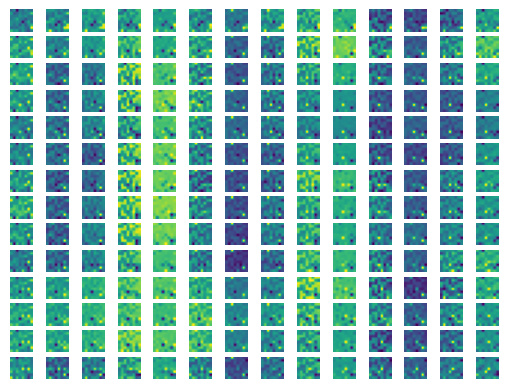

In [31]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision.models import ViT_B_16_Weights

vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
# vit.heads = nn.Linear(768, 4)

# vit.load_state_dict(torch.load("vit.pth"))
vit.eval()

print(vit.encoder.pos_embedding)
print(vit.encoder.pos_embedding.size())
figs, axes = plt.subplots(14, 14)
for i in range(14):
    for j in range(14):
        axes[i, j].imshow(np.reshape(vit.encoder.pos_embedding[0, 1 + 14*i + j, :64].detach().cpu().numpy(), (8, 8)))
        axes[i, j].axis("off")

In [35]:
import cv2
import random
import glob

glioma_img = cv2.imread(random.choice(glob.glob("data/Training/glioma_tumor/*.jpg")), cv2.COLOR_BGR2RGB)
input = torch.unsqueeze(torch.tensor(np.transpose(cv2.resize(glioma_img, (224, 224)), [2, 0, 1]), dtype=torch.float32)/255.0, dim=0)

vit.eval()
x = vit._process_input(input)
n = x.shape[0]

# Expand the class token to the full batch
batch_class_token = vit.class_token.expand(n, -1, -1)
x = torch.cat([batch_class_token, x], dim=1)
x = x + vit.encoder.pos_embedding
for layer in vit.encoder.layers:
    dist = []
    y = layer.ln_1(x)
    _, attention_weight = layer.self_attention(y, y, y) # attention_weight = softmax(query * key')
    attention_weight = np.squeeze(attention_weight.detach().cpu().numpy())
    print(np.max(attention_weight))
    print(attention_weight.shape)
    for query_i in range(1, 224, 16):
        for query_j in range(1, 224, 16):
            patch_idx, patch_idy = int(np.floor(query_i/16)), int(np.floor(query_j/16))
            for other_i in range(1, 224, 16):
                for other_j in range(1, 224, 16):
                    other_idx, other_idy = int(np.floor(other_i/16)), int(np.floor(other_j/16))
                    dist.append(attention_weight[(patch_idx)*14+patch_idy+1, (other_idx)*14+other_idy+1]*np.sqrt(((query_i-other_i)**2+(query_j-other_j)**2)))
    print(np.mean(dist))
    x = layer(x)
    
    

0.2181505
(197, 197)
0.5230639952634965
0.45484838
(197, 197)
0.4624991796602232
0.49642524
(197, 197)
0.39409851899385373
0.54061973
(197, 197)
0.36741853758490983
0.49046513
(197, 197)
0.36514659261890814
0.54934186
(197, 197)
0.45058226096617854
0.40171316
(197, 197)
0.45735719710824846
0.30632132
(197, 197)
0.5167512948766589
0.21721017
(197, 197)
0.5619871374751073
0.10372543
(197, 197)
0.5816178300967456
0.15206876
(197, 197)
0.5899289584195577
0.14150475
(197, 197)
0.610076031286042


In [10]:
import numpy as np
import tqdm
from sklearn.metrics import classification_report

import torch
from torch.optim import Adam
import torchvision
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader

from torchinfo import summary

import wandb

model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 4)

print(summary(model, input_size=(1, 3, 224, 224)))

device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = TumorDataset("data/Training",
                             train=True,
                             transform=transform(True),
                             )
test_dataset = TumorDataset("data/Testing",
                            train=False,
                            transform=transform(False),
                            )
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True,
                              drop_last=True,
                              )
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             drop_last=False,
                             )

model.train()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), betas=[0.9, 0.99], lr=1e-4)

scaler = torch.cuda.amp.GradScaler()
wandb.init(project="tumor-classification")

for epoch in range(10):
    model.train()
    for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        imgs, labels = batch[0], batch[1]

        pred = model(imgs.to(device))
        loss = loss_fn(pred, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        wandb.log({"loss": loss})

    predictions = []
    targets = []
    model.eval()
    for item in test_dataset:
        img, label = item[0], item[1]

        # with torch.autocast(device_type="cuda", dtype=torch.float16):
        with torch.no_grad():
            pred = model(torch.unsqueeze(img, dim=0).to(device))

        pred = torch.argmax(pred, dim=-1).detach().cpu().numpy()
        predictions.append(pred)
        targets.append(label.detach().cpu().numpy())


    print(classification_report(targets, predictions))

torch.save(model.state_dict(), "resnet18.pth")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

loss,█▇▆▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁
loss,0.11898


100%|██████████| 51/51 [01:00<00:00,  1.18s/it]


              precision    recall  f1-score   support

           0       0.95      0.18      0.30       100
           1       0.68      0.83      0.75       115
           2       0.47      0.96      0.63       105
           3       0.94      0.23      0.37        74

    accuracy                           0.59       394
   macro avg       0.76      0.55      0.51       394
weighted avg       0.74      0.59      0.53       394



100%|██████████| 51/51 [00:54<00:00,  1.08s/it]


              precision    recall  f1-score   support

           0       1.00      0.19      0.32       100
           1       0.65      0.90      0.75       115
           2       0.58      1.00      0.73       105
           3       0.97      0.43      0.60        74

    accuracy                           0.66       394
   macro avg       0.80      0.63      0.60       394
weighted avg       0.78      0.66      0.61       394



100%|██████████| 51/51 [00:54<00:00,  1.07s/it]


              precision    recall  f1-score   support

           0       0.97      0.30      0.46       100
           1       0.72      0.95      0.82       115
           2       0.76      1.00      0.86       105
           3       0.88      0.86      0.87        74

    accuracy                           0.78       394
   macro avg       0.83      0.78      0.75       394
weighted avg       0.82      0.78      0.75       394



100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


              precision    recall  f1-score   support

           0       1.00      0.27      0.43       100
           1       0.73      0.97      0.83       115
           2       0.66      1.00      0.80       105
           3       0.95      0.72      0.82        74

    accuracy                           0.75       394
   macro avg       0.83      0.74      0.72       394
weighted avg       0.82      0.75      0.72       394



100%|██████████| 51/51 [00:55<00:00,  1.09s/it]


              precision    recall  f1-score   support

           0       1.00      0.24      0.39       100
           1       0.72      0.99      0.83       115
           2       0.70      1.00      0.83       105
           3       0.94      0.78      0.85        74

    accuracy                           0.76       394
   macro avg       0.84      0.75      0.72       394
weighted avg       0.83      0.76      0.72       394



100%|██████████| 51/51 [00:54<00:00,  1.08s/it]


              precision    recall  f1-score   support

           0       1.00      0.28      0.44       100
           1       0.66      0.99      0.79       115
           2       0.81      1.00      0.90       105
           3       0.97      0.82      0.89        74

    accuracy                           0.78       394
   macro avg       0.86      0.77      0.75       394
weighted avg       0.84      0.78      0.75       394



100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


              precision    recall  f1-score   support

           0       1.00      0.32      0.48       100
           1       0.73      0.99      0.84       115
           2       0.77      1.00      0.87       105
           3       0.96      0.91      0.93        74

    accuracy                           0.81       394
   macro avg       0.86      0.80      0.78       394
weighted avg       0.85      0.81      0.78       394



100%|██████████| 51/51 [00:54<00:00,  1.07s/it]


              precision    recall  f1-score   support

           0       0.90      0.26      0.40       100
           1       0.73      0.99      0.84       115
           2       0.73      1.00      0.84       105
           3       0.95      0.84      0.89        74

    accuracy                           0.78       394
   macro avg       0.83      0.77      0.74       394
weighted avg       0.81      0.78      0.74       394



100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


              precision    recall  f1-score   support

           0       1.00      0.38      0.55       100
           1       0.71      0.99      0.83       115
           2       0.82      1.00      0.90       105
           3       0.96      0.88      0.92        74

    accuracy                           0.82       394
   macro avg       0.87      0.81      0.80       394
weighted avg       0.86      0.82      0.79       394



100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


              precision    recall  f1-score   support

           0       1.00      0.43      0.60       100
           1       0.75      0.99      0.86       115
           2       0.78      1.00      0.88       105
           3       0.98      0.86      0.92        74

    accuracy                           0.83       394
   macro avg       0.88      0.82      0.81       394
weighted avg       0.87      0.83      0.81       394



In [11]:
from sklearn.metrics import classification_report

predictions = []
targets = []
vit.eval()
for item in test_dataset:
    img, label = item[0], item[1]

    with torch.no_grad():
        pred = vit(torch.unsqueeze(img, dim=0).to(device))

    pred = torch.argmax(pred, dim=-1).detach().cpu().numpy()
    predictions.append(pred)
    targets.append(label.detach().cpu().numpy())


print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.97      0.31      0.47       100
           1       0.71      0.88      0.79       115
           2       0.66      1.00      0.80       105
           3       0.98      0.81      0.89        74

    accuracy                           0.75       394
   macro avg       0.83      0.75      0.74       394
weighted avg       0.81      0.75      0.73       394

